In [1]:
import sys
import statistics
import math
import matplotlib.pyplot as plt

In [2]:
sys.path.append("..")

In [3]:
from carca.data import CARCADataset, load_attrs, load_ctx, load_profiles

In [51]:
ds_name = "video_games"
attrs = load_attrs(ds_name)
ctx = load_ctx(ds_name)
user_ids, item_ids, profiles = load_profiles(ds_name)

In [52]:
n_sessions = len(profiles)
multi_sess = sum(len(p) > 1 for p in profiles.values())
avg_l = statistics.mean(len(p) for p in profiles.values())
std_l = statistics.stdev(len(p) for p in profiles.values())
max_l = max(len(p) for p in profiles.values())
min_l = min(len(p) for p in profiles.values())

In [53]:
v_labels = list(range(2, 31))
v_counts = [sum(len(p) == i for p in profiles.values()) for i in range(2, 31)]

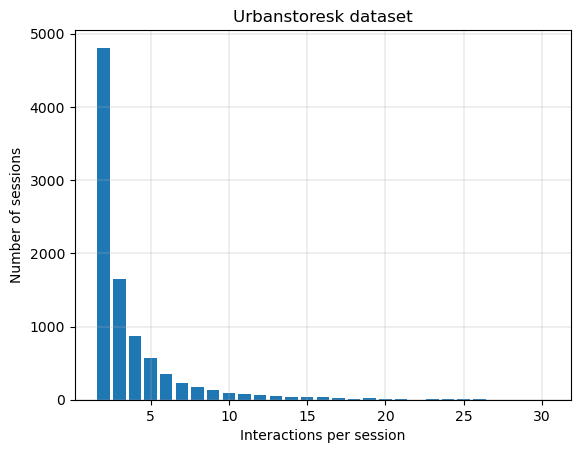

In [46]:
# Only sessions with length > 1
plt.bar(u_labels, u_counts)
plt.xlabel("Interactions per session")
plt.ylabel("Number of sessions")
plt.title(f"{ds_name.capitalize()} dataset")
plt.grid(linewidth=0.3)
plt.show()

In [30]:
print(f"# sessions - {n_sessions}; # sessions > 1 - {multi_sess}; Average length - {avg_l}; Std - {std_l}; Max - {max_l}; Min - {min_l}")

# sessions - 45184; # sessions > 1 - 45184; Average length - 7.9232250354107645; Std - 5.64240011064885; Max - 192; Min - 5


| Dataset | # Sessions | # Sessions > 1 | Average length | Std | Max | Min |
| --- | --- | --- | --- | --- | --- | --- |
| Beauty | 52204 | 51744 | 7.56 | 7.62 | 293 | 1 |
| Fashion | 45184 | 45184 | 7.92 | 5.64 | 192 | 5 |
| Men | 34244 | 34244 | 7.44 | 4.73 | 308 | 5 |
| Video Games | 31013 | 30983 | 9.26 | 13.21 | 860 | 1 |
| Urbanstore.sk | 48764 | 9315 | 1.54 | 1.97 | 80 | 1 |

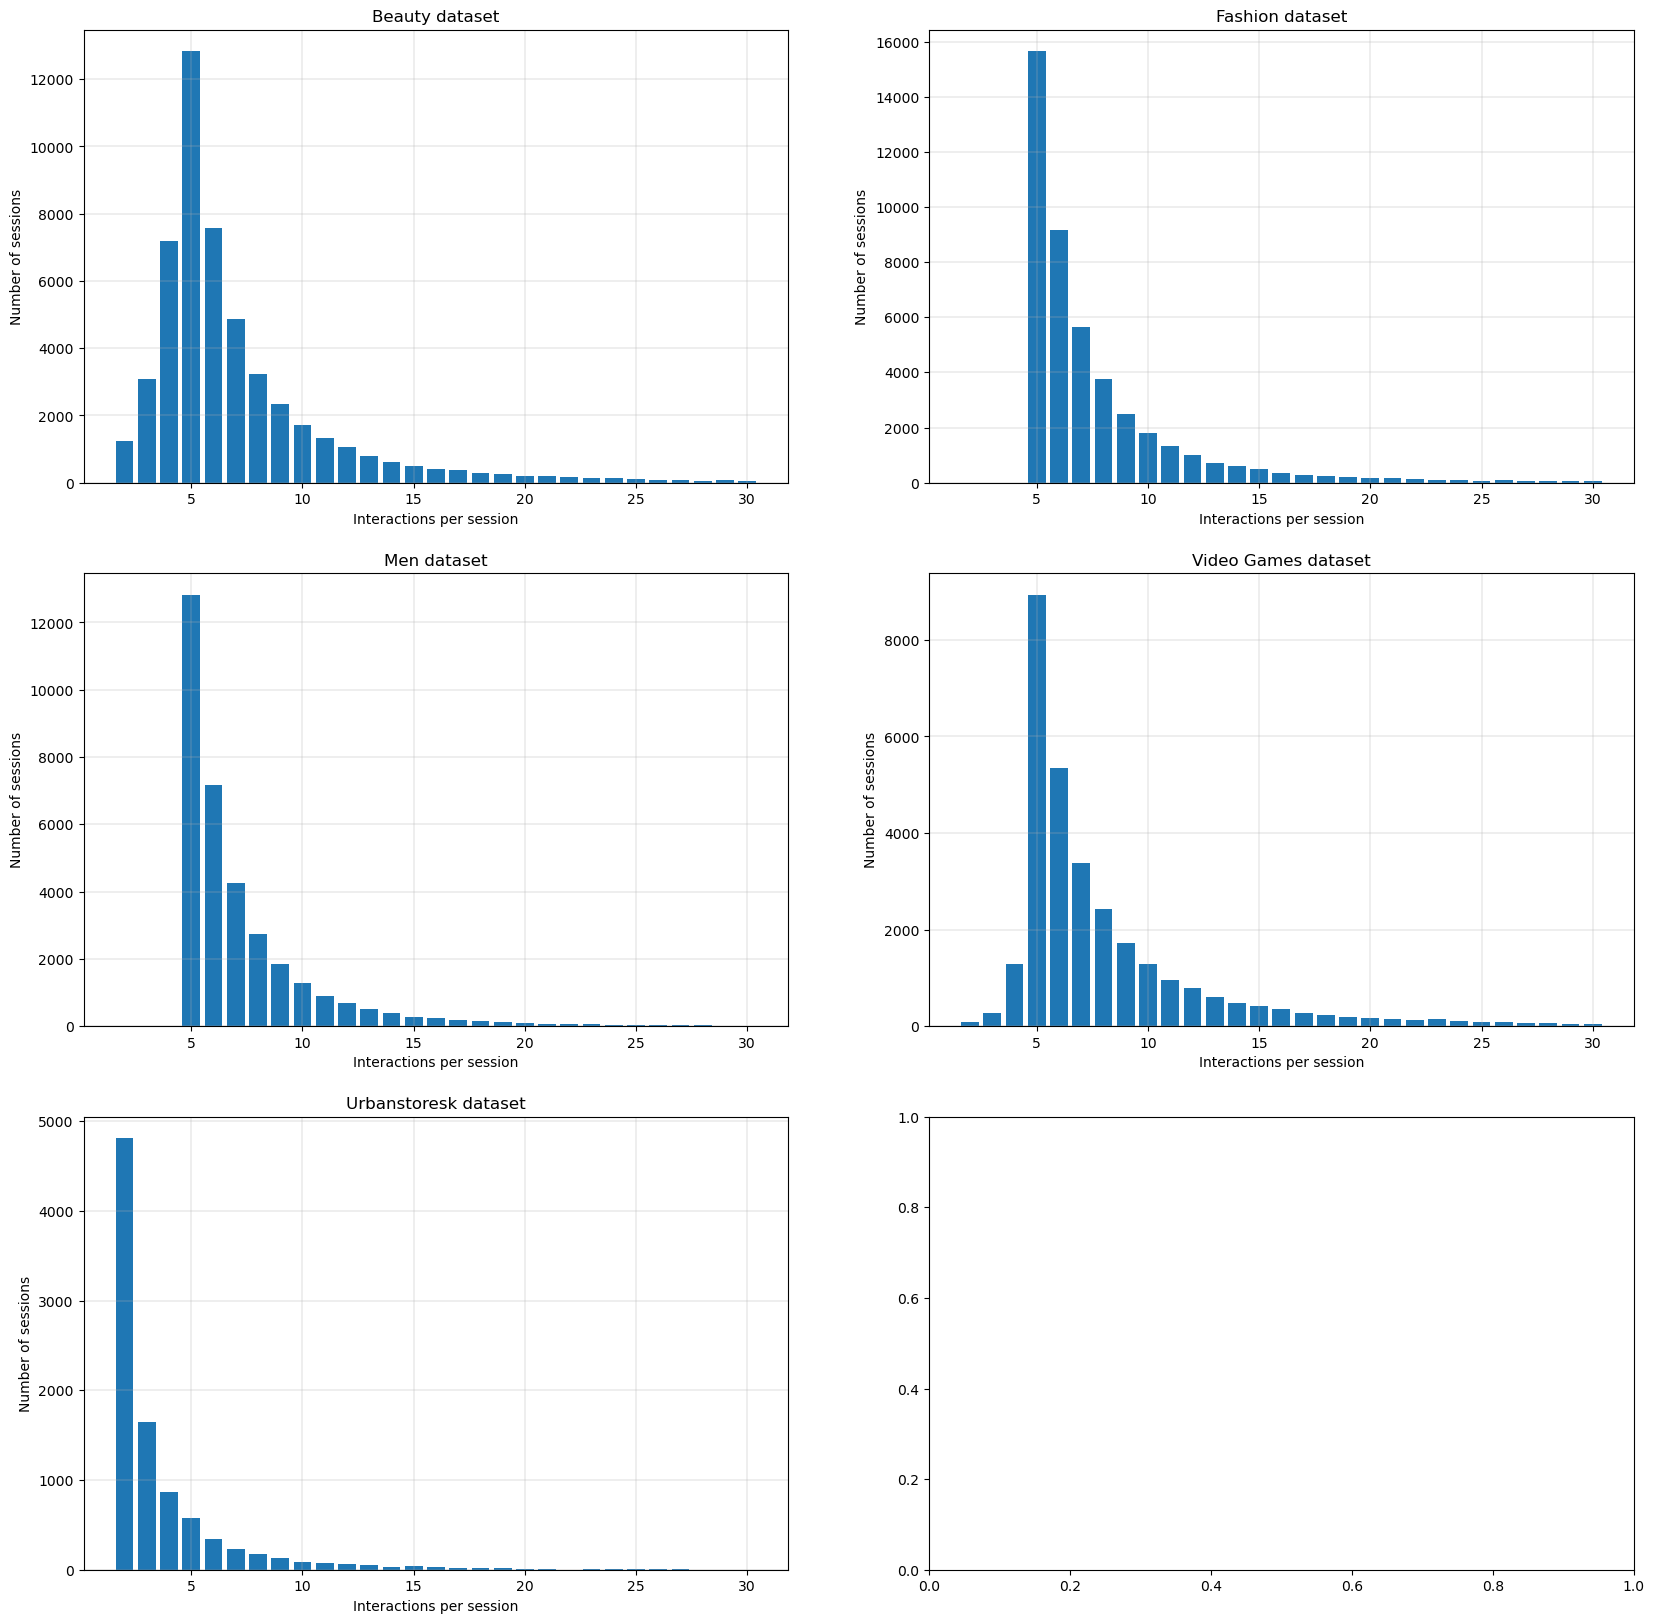

In [54]:
fig, axs = plt.subplots(3, 2, figsize=(20, 20))

axs[0, 0].bar(b_labels, b_counts)
axs[0, 0].set(xlabel="Interactions per session", ylabel="Number of sessions", title="Beauty dataset")
axs[0, 0].grid(linewidth=0.3)

axs[0, 1].bar(f_labels, f_counts)
axs[0, 1].set(xlabel="Interactions per session", ylabel="Number of sessions", title="Fashion dataset")
axs[0, 1].grid(linewidth=0.3)

axs[1, 0].bar(m_labels, m_counts)
axs[1, 0].set(xlabel="Interactions per session", ylabel="Number of sessions", title="Men dataset")
axs[1, 0].grid(linewidth=0.3)

axs[1, 1].bar(v_labels, v_counts)
axs[1, 1].set(xlabel="Interactions per session", ylabel="Number of sessions", title="Video Games dataset")
axs[1, 1].grid(linewidth=0.3)

axs[2, 0].bar(u_labels, u_counts)
axs[2, 0].set(xlabel="Interactions per session", ylabel="Number of sessions", title="Urbanstoresk dataset")
axs[2, 0].grid(linewidth=0.3)